### 데이터 전처리 + train/test 분리

In [8]:
import pandas as pd

df = pd.read_csv("./올영_세일.csv", encoding="utf-8")
df.head()

,page,name,price,orig_price,url
0,1,메디힐\n[2025 어워즈/14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 10+...,"9,900원 ~","20,000원 ~",https://www.oliveyoung.co.kr/store/goods/getGo...
1,1,일리윤\n[어워즈특가] 일리윤 세라마이드 아토 로션 600+334ML 어워즈 한정기획,"24,500원","39,500원",https://www.oliveyoung.co.kr/store/goods/getGo...
2,1,에스트라\n[어워즈특가] 에스트라 아토베리어365 크림 80ml 어워즈 한정기획 (...,"24,700원","33,000원",https://www.oliveyoung.co.kr/store/goods/getGo...
3,1,토리든\n[어워즈특가/1등 세럼] 토리든 다이브인 저분자 히알루론산 세럼 100ml...,"33,250원","50,000원",https://www.oliveyoung.co.kr/store/goods/getGo...
4,1,메디큐브 에이지알\n[어워즈특가] 메디큐브 에이지알 부스터프로 미니플러스 짱구 에디...,"115,900원 ~","126,000원 ~",https://www.oliveyoung.co.kr/store/goods/getGo...


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("./올영_세일.csv", encoding="utf-8")

def to_num(x):
    if pd.isna(x):
        return None
    x = str(x).replace("원","").replace(",","").replace("~","").strip()
    return int(x) if x.isdigit() else None

df["price_num"] = df["price"].apply(to_num)
df["orig_price_num"] = df["orig_price"].apply(to_num)

df["discount_rate"] = (df["orig_price_num"] - df["price_num"]) / df["orig_price_num"]
df["discount_rate"] = df["discount_rate"].fillna(0)

df["rank"] = df.index + 1

df_model = df[["price_num", "orig_price_num", "discount_rate", "rank"]].dropna()

X = df_model[["price_num", "orig_price_num", "discount_rate"]]
y = df_model["rank"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("전처리 완료. X_train / y_train 생성됨.")

전처리 완료. X_train / y_train 생성됨.


In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### 로지스틱 회귀

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 상위 10% 인기상품
threshold = int(len(df_model) * 0.1)
df_model["is_top"] = (df_model["rank"] <= threshold).astype(int)

X_cls = df_model[["price_num","orig_price_num","discount_rate"]]
y_cls = df_model["is_top"]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

logit = LogisticRegression(max_iter=1000)
logit.fit(Xc_train, yc_train)

pred_prob = logit.predict_proba(Xc_test)[:,1]
pred_cls = (pred_prob >= 0.5).astype(int)

acc = accuracy_score(yc_test, pred_cls)
auc = roc_auc_score(yc_test, pred_prob)

print("📌 Logistic Regression (Top 10% 분류)")
print("Accuracy:", acc)
print("ROC-AUC:", auc)
print("Coefficients:", dict(zip(X_cls.columns, logit.coef_[0])))
print("Intercept:", logit.intercept_[0])

📌 Logistic Regression (Top 10% 분류)
Accuracy: 0.8958333333333334
ROC-AUC: 0.6186342592592593
Coefficients: {'price_num': np.float64(-6.7598215215506024e-06), 'orig_price_num': np.float64(8.238850095799414e-06), 'discount_rate': np.float64(-0.5990940938277017)}
Intercept: -2.1262574517298303


#### 다중선형 회귀

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)

print("📌 Linear Regression")
print("MAE:", mae_lr)
print("R2:", r2_lr)
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

📌 Linear Regression
MAE: 299.8622564807709
R2: -0.02655361358922459
Coefficients: [-3.15539368e-03  1.05153133e-03 -5.39679801e+01]
Intercept: 652.6288857677612


#### 랜덤 포레스트 회귀

In [17]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=10
)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print("\n📌 Random Forest Regressor")
print("MAE:", mae_rf)
print("R2:", r2_rf)

# 변수 중요도
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(importances)


📌 Random Forest Regressor
MAE: 289.2380542983209
R2: 0.017888336013153094

Feature Importances:
price_num         0.376826
orig_price_num    0.249772
discount_rate     0.373402
dtype: float64


#### 모델 성능 비교

####  Gradient Boosting Regressor

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)

pred_gbr = gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, pred_gbr)
r2_gbr = r2_score(y_test, pred_gbr)

print("📌 GradientBoostingRegressor")
print("MAE:", mae_gbr)
print("R2:", r2_gbr)

📌 GradientBoostingRegressor
MAE: 285.55212201640086
R2: 0.046497233136034155


#### XGBoost Regressor

In [19]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
xgb.fit(X_train, y_train)

pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, pred_xgb)
r2_xgb = r2_score(y_test, pred_xgb)

print("\n📌 XGBRegressor")
print("MAE:", mae_xgb)
print("R2:", r2_xgb)


📌 XGBRegressor
MAE: 282.80255126953125
R2: 0.0415424108505249


#### 가성비 스코어(price/효과) 기반 추천 모델

In [20]:
from sklearn.preprocessing import MinMaxScaler

df_val = df_model.copy()

scaler = MinMaxScaler()

df_val[["price_norm","orig_price_norm","disc_norm","rank_norm"]] = scaler.fit_transform(
    df_val[["price_num","orig_price_num","discount_rate","rank"]]
)

# 반전
df_val["rank_good"] = 1 - df_val["rank_norm"]

# 가성비 스코어: (할인율, 낮은 가격, 높은 인기)
# 가중치 조정 가능
df_val["value_score"] = (
    0.4 * df_val["disc_norm"] +      # 할인율
    0.3 * (1 - df_val["price_norm"]) + 
    0.3 * df_val["rank_good"]        # 순위
)

# 가성비 TOP 30
top_value = df_val.join(df[["name","url"]], how="left")
top_value = top_value.sort_values("value_score", ascending=False).head(30)

top_value[["rank","value_score","price_num","orig_price_num","discount_rate","name","url"]]

,rank,value_score,price_num,orig_price_num,discount_rate,name,url
7,8,0.905003,17390,40000,0.565250,넘버즈인\n넘버즈인 1번~5번 마스크팩 10매 기획 5종 중 택 1,https://www.oliveyoung.co.kr/store/goods/getGo...
27,28,0.891689,25900,58500,0.557265,아누아\n[현재 영통팬싸 이벤트/어워즈특가] 아누아 피디알엔 히알루론산 캡슐 100...,https://www.oliveyoung.co.kr/store/goods/getGo...
126,127,0.882406,26550,64000,0.585156,아누아\n[현재 영통팬싸 이벤트/단독기획] 아누아 피디알엔 히알루론산 100 수분크...,https://www.oliveyoung.co.kr/store/goods/getGo...
51,52,0.878552,950,2000,0.525000,메디힐\n[14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 1매 고기능 7종 택1,https://www.oliveyoung.co.kr/store/goods/getGo...
114,115,0.876167,20700,47500,0.564211,피지오겔\n피지오겔 DMT 페이셜 보습장벽 크림 150ml,https://www.oliveyoung.co.kr/store/goods/getGo...
0,1,0.876011,9900,20000,0.505000,메디힐\n[2025 어워즈/14년연속 누적판매 1위] 메디힐 에센셜 마스크팩 10+...,https://www.oliveyoung.co.kr/store/goods/getGo...
11,12,0.874917,20790,43000,0.516512,에스네이처\n[어워즈특가/수분천재크림] 에스네이처 아쿠아 스쿠알란 수분크림 60ml...,https://www.oliveyoung.co.kr/store/goods/getGo...
93,94,0.872180,23400,52000,0.550000,일소\n[어워즈특가] 일소 슈퍼 멜팅 세범 소프트너 150g 어워즈 한정기획 (+1...,https://www.oliveyoung.co.kr/store/goods/getGo...
66,67,0.863847,26600,56100,0.525847,브링그린\n[2025 연말결산특가] 브링그린 징크테카 트러블 세럼 (대용량/콜라보/기획),https://www.oliveyoung.co.kr/store/goods/getGo...
67,68,0.859743,14710,30000,0.509667,토리든\n[어워즈특가/1등 마스크] 토리든 다이브인 저분자 히알루론산 마스크 12매...,https://www.oliveyoung.co.kr/store/goods/getGo...


#### 브랜드별 인기 예측 (모델 활용)

In [21]:

df_model_with_brand = df_model.copy()
df_model_with_brand["brand"] = df.loc[df_model.index, "name"].apply(
    lambda x: str(x).split("\n")[0].split()[0]
)


y_pred_all = xgb.predict(df_model_with_brand[["price_num","orig_price_num","discount_rate"]])
df_model_with_brand["pred_rank"] = y_pred_all

brand_pop = df_model_with_brand.groupby("brand").agg(
    real_rank_mean=("rank","mean"),
    pred_rank_mean=("pred_rank","mean"),
    cnt=("rank","count")
).sort_values("real_rank_mean")  

brand_pop.head(20)

,real_rank_mean,pred_rank_mean,cnt
brand,,,
베리시,39.00,423.336365,1
연작,46.00,393.168213,1
릴리이브,48.00,307.743713,1
밀잇,66.00,341.092163,1
닥터브로너스,70.00,352.578369,1
얼터너티브스테레오,72.00,764.882202,2
어반디케이,104.00,347.027466,1
체이싱래빗,109.00,585.202271,1
닥터아돌,110.00,345.728119,1


#### SHAP analysis (변수 영향 설명)

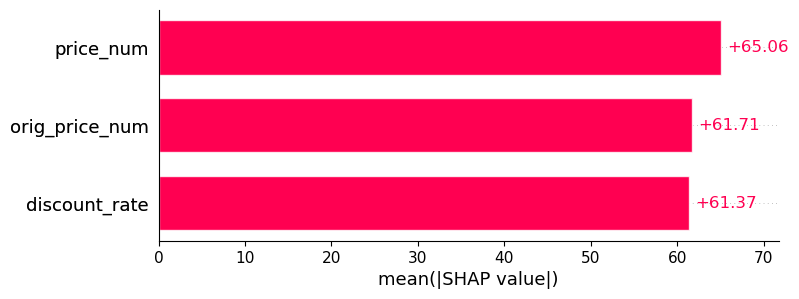

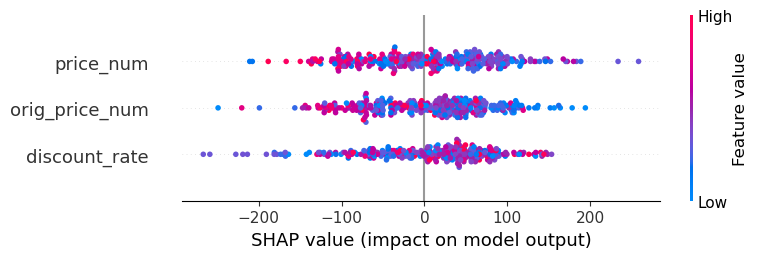

In [23]:
import shap
X_sample = X.sample(300, random_state=42)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_sample)

shap.plots.bar(shap_values, max_display=10)

shap.summary_plot(shap_values, X_sample)